# Plot the rerouting effect

This notebook shows how you can reproduce the figures showing the rerouting effect on the embeddings using PCA. 

Requirements: 
- Model's information in `models.toml` if you want to use the `Lens.from_config` method

In [1]:
from ssr.lens import Lens 
lens = Lens.from_preset("llama3.2_1b")

Loaded pretrained model meta-llama/Llama-3.2-1B-Instruct into HookedTransformer


In [2]:
import torch as t
from typing import Optional
from functools import partial
import transformer_lens as tl
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from accelerate.utils.memory import release_memory
import numpy as np
import einops

from ssr import VIOLET, ORANGE, TURQUOISE, PINK, pprint
from ssr.files import load_dataset
from ssr.evaluation import load_attempts_jsonl
from ssr.memory import find_executable_batch_size

In [3]:
attempts = load_attempts_jsonl("generated_jailbreaks/filtered/llama3.2_1b_probes.jsonl")
from rich import print
attempts_before = []
attempts_after = []
MAX_ATTEMPTS = 4
for attempt in attempts[:MAX_ATTEMPTS]:
    attempts_before.append(attempt.vanilla_input)
    attempts_after.append(attempt.adversarial_input)

### Process the datasets using the same configuration 

In [4]:
MAX_SAMPLES = 120

hf, hl = lens.process_dataset(*load_dataset(lens.defaults.dataset_name, max_samples=MAX_SAMPLES))
ab, aa = lens.process_dataset(attempts_before, attempts_after)
_, hf_cache = lens.auto_scan(hf, pattern="resid_post")
_, hl_cache = lens.auto_scan(hl, pattern="resid_post")
_, ab_cache = lens.auto_scan(ab, pattern="resid_post")
_, aa_cache = lens.auto_scan(aa, pattern="resid_post")

hf_scan = hf_cache.stack_activation("resid_post")
hl_scan = hl_cache.stack_activation("resid_post")
ab_scan = ab_cache.stack_activation("resid_post")
aa_scan = aa_cache.stack_activation("resid_post")

hf_acts = hf_scan[:, :, -1, :]
hl_acts = hl_scan[:, :, -1, :]
ab_acts = ab_scan[:, :, -1, :]
aa_acts = aa_scan[:, :, -1, :]

pprint(
    hf_scan.shape, 
    hl_scan.shape,
    ab_scan.shape, 
    aa_scan.shape
)

pprint(f""" 
torch.Size([16, {MAX_SAMPLES}, 44, 2048])
torch.Size([16, {MAX_SAMPLES}, 43, 2048])
torch.Size([16, {MAX_ATTEMPTS}, ?, 2048])
torch.Size([16, {MAX_ATTEMPTS}, ?, 2048])
""")

100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


torch.Size([16, 120, 44, 2048])
torch.Size([16, 120, 43, 2048])
torch.Size([16, 4, 40, 2048])
torch.Size([16, 4, 55, 2048])

torch.Size([16, 120, 44, 2048])
torch.Size([16, 120, 43, 2048])
torch.Size([16, 4, ?, 2048])
torch.Size([16, 4, ?, 2048])

In [5]:
full_scan_last = t.cat([
        hf_acts,
        hl_acts,
        ab_acts,
        aa_acts,
    ], 
    dim=1
)
pprint(full_scan_last.shape)

pprint(f"torch.Size([16, {2*MAX_ATTEMPTS+2*MAX_SAMPLES}, 2048])")

torch.Size([16, 248, 2048])

torch.Size([16, 248, 2048])

In [6]:
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 17,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 11,
    'figure.titlesize': 18
})

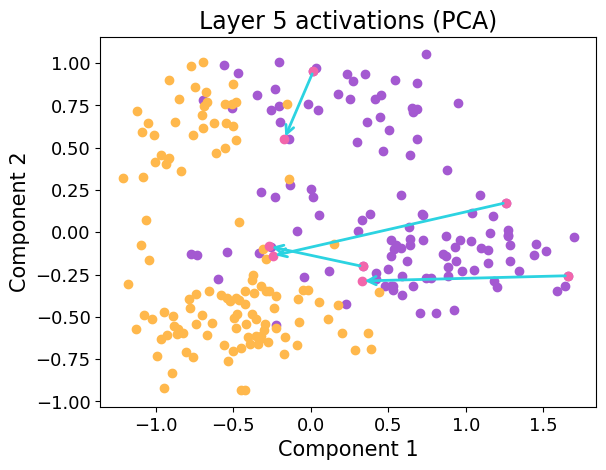

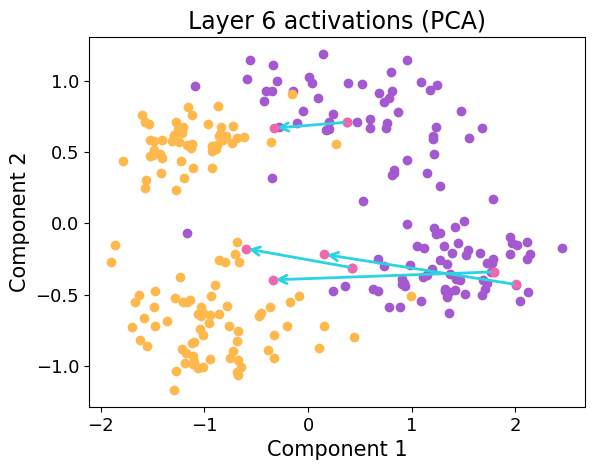

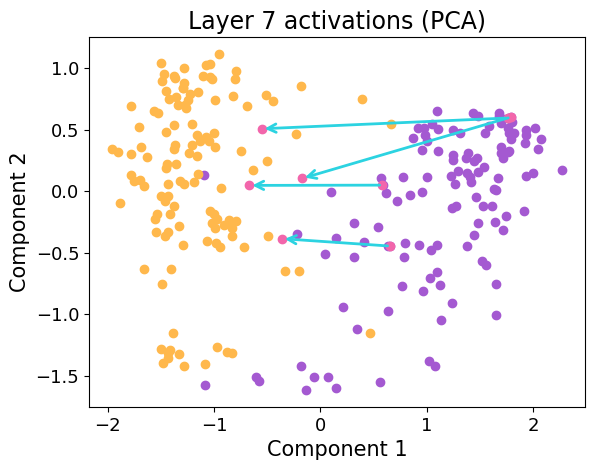

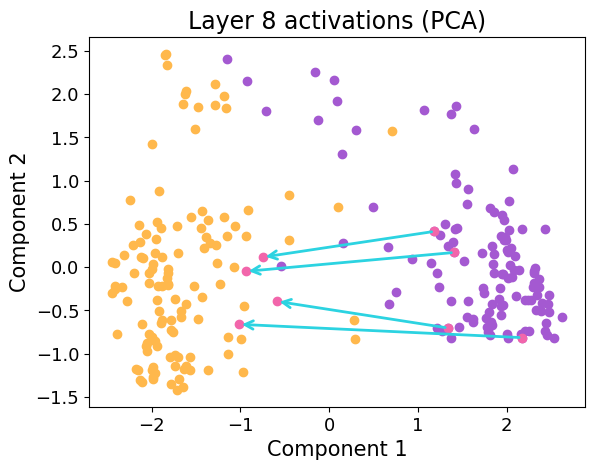

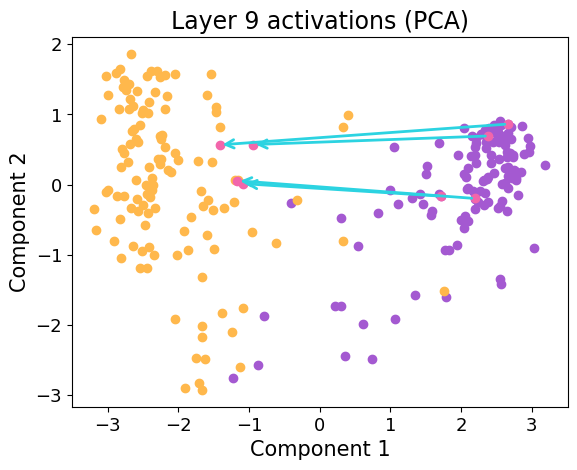

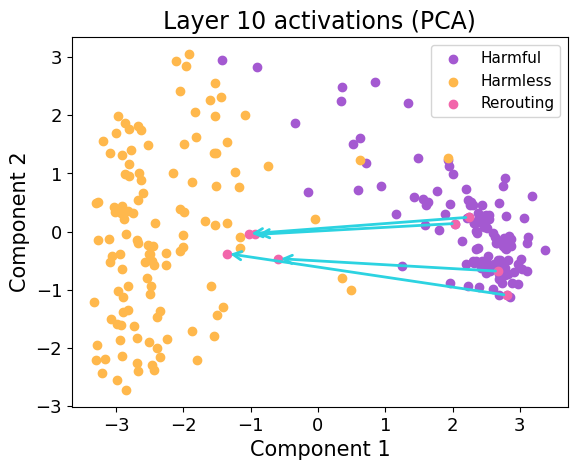

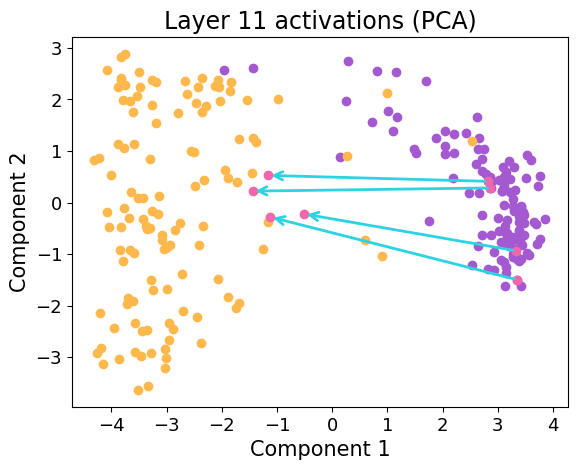

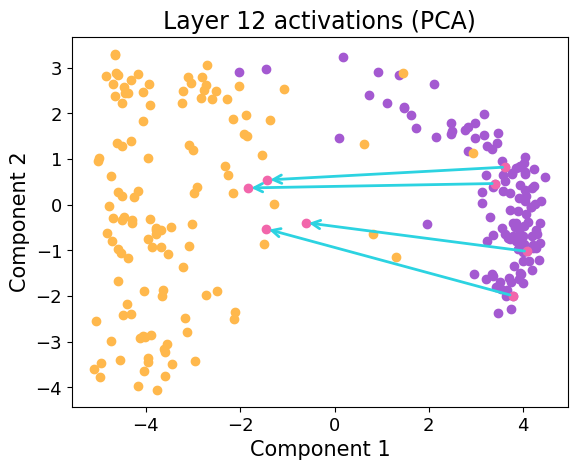

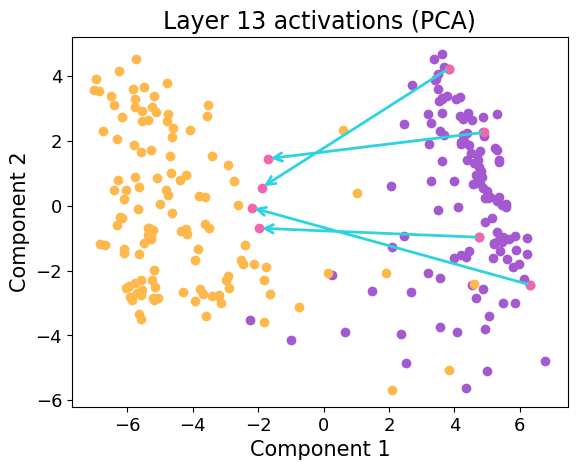

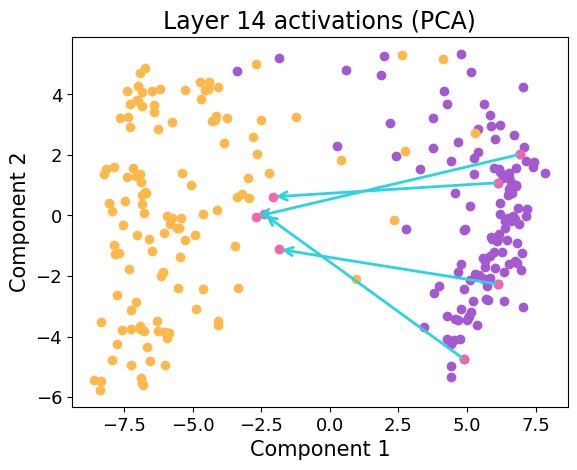

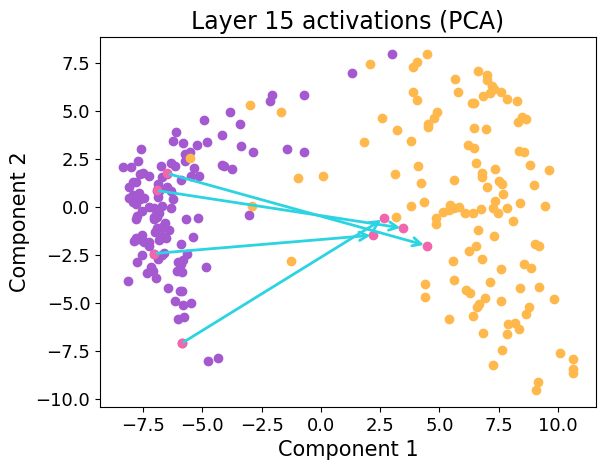

In [9]:
activations = full_scan_last.detach().float().numpy()
n_layers = lens.model.cfg.n_layers

pca_list = []
reduced_activations = []

for layer in range(n_layers):
    pca = PCA(n_components=2)
    x_reduced = pca.fit_transform(activations[layer])

    pca_list.append(pca)
    reduced_activations.append(x_reduced)

starting_layer = 5

for k, x in enumerate(reduced_activations[starting_layer:]):
    a, b, c, d = x[:MAX_SAMPLES], x[MAX_SAMPLES:2*MAX_SAMPLES], x[2*MAX_SAMPLES:2*MAX_SAMPLES+MAX_ATTEMPTS], x[2*MAX_SAMPLES+MAX_ATTEMPTS:]

    fig, ax = plt.subplots()
    ax.scatter(
        a[:, 0],
        a[:, 1],
        label="Harmful",
        color=VIOLET,
    )
    ax.scatter(
        b[:, 0], 
        b[:, 1],
        label="Harmless",
        color=ORANGE,
    )
    ax.scatter(
        c[:, 0], 
        c[:, 1],
        label="Rerouting",
        color=PINK,
    )
    ax.scatter(
        d[:, 0], 
        d[:, 1],
        color=PINK,
    )

    for start, finish in zip(c, d):
        ax.annotate('',
                xy=(finish[0], finish[1]),  # End point (arrow head)
                xytext=(start[0], start[1]),  # Start point (arrow tail)
                arrowprops=dict(
                    arrowstyle='->',
                    color=TURQUOISE,
                    lw=2,
                    ls='-'
                ))

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"Layer {k+starting_layer} activations (PCA)")
    if k+starting_layer==10:
        plt.legend()
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    plt.savefig(f"rerouting_{k+starting_layer}.svg", transparent=True)
    plt.show()